In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy.interpolate as si
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.base import TransformerMixin
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression, RANSACRegressor, TheilSenRegressor, HuberRegressor

# Make up some data

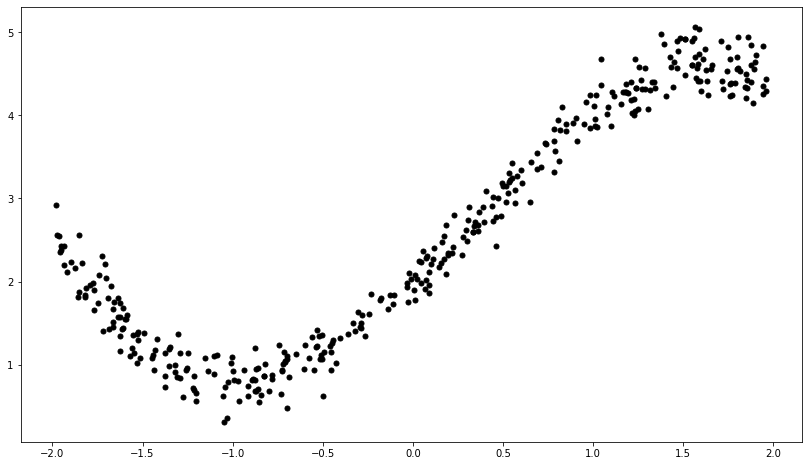

In [21]:
np.random.seed(42)
X = np.random.uniform(low=-2, high=2, size=500)

model = 'polynomial'

if model == 'polynomial':
    y = 2. + 2 *X  + .4*X**2 - .4 * X**3
elif model == 'periodic':
    y = np.sin(20 * np.pi * 0.1 * X)
X = X[:,np.newaxis]

# random normal error
error = 0.2 * np.random.randn(y.shape[0])

# generate observations with additive noise
y += error 

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42)

x_predict = np.linspace(-2, 2, 1000)


fig, ax = plt.subplots(1, 1, figsize=(14, 8))
ax.plot(X_train, y_train, 'o', ms=5, c='black',
        label='data points [10% outliers]');

# Polynomial Features

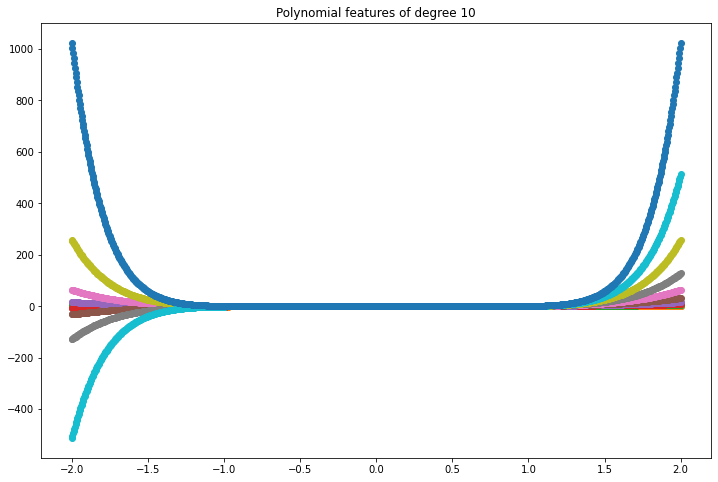

In [22]:

degree=10

pf = PolynomialFeatures(degree)
poly_features = pf.fit_transform(x_predict[:,None])

plt.figure(figsize=(12,8))
plt.plot(x_predict, poly_features,'o')
plt.title('Polynomial features of degree ' + str(degree))
plt.show()

In [23]:
poly_features.shape

(1000, 11)

# Set up a few Regression Estimators

In [24]:
estimators = [('Least-Square', '-', 'C0', LinearRegression(fit_intercept=False)),
              ('Theil-Sen', '-', 'C1', TheilSenRegressor(random_state=42)),
              ('RANSAC', '-', 'C2', RANSACRegressor(random_state=42)),
              ('HuberRegressor', '-', 'C3', HuberRegressor())]


# Compare The Feature-map regressions

C:\Users\22718\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\linear_model\_huber.py:332: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


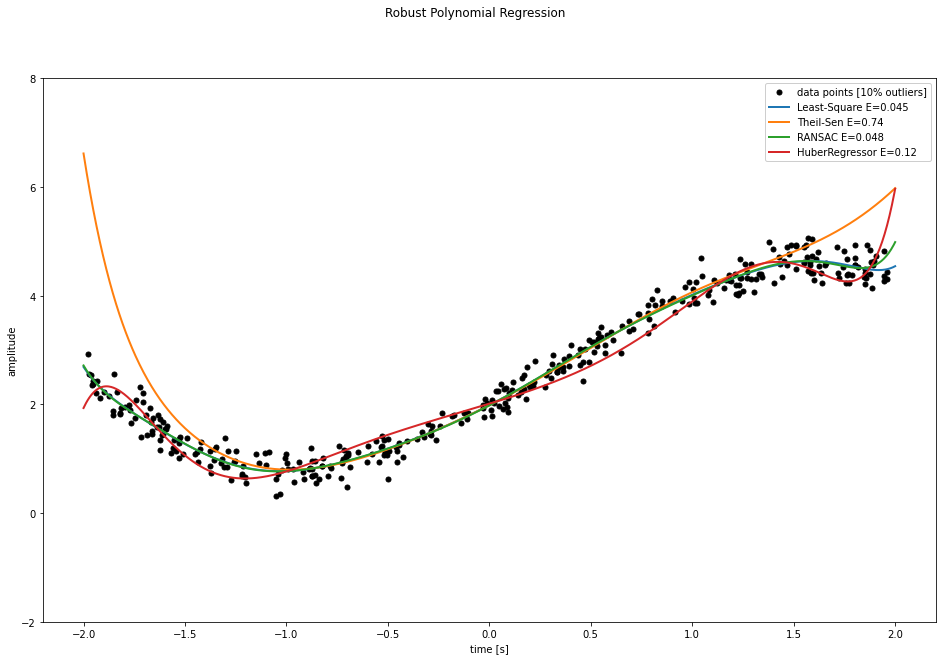

In [25]:
fig, ax = plt.subplots(1, 1, figsize=(16, 10))
fig.suptitle('Robust Polynomial Regression')
ax.plot(X_train, y_train, 'o', ms=5, c='black',
        label='data points [10% outliers]')

for label, style, color, estimator in estimators:
    model = make_pipeline(pf, estimator)
    model.fit(X_train, y_train)
    mse = mean_squared_error(model.predict(X_test), y_test)
    y_predicted = model.predict(x_predict[:, None])
    ix = np.argsort(x_predict)
    ax.plot(x_predict[ix], y_predicted[ix], style, lw=2,
            color=color, label=label + ' E={:2.2g}'.format(mse))
ax.legend(loc='upper right', framealpha=0.95)
ax.set(ylim=(-2, 8), xlabel='time [s]', ylabel='amplitude')
# ax.set_xlim(-1,1)
# ax.set_ylim(-2,2)
plt.show()


# Define B-Spline features

In [26]:
"""
Robust B-Spline regression with scikit-learn
"""

def get_bspline_basis(knots, degree=3, periodic=False):
    """Get spline coefficients for each basis spline."""
    nknots = len(knots)
    y_dummy = np.zeros(nknots)

    knots, coeffs, degree = si.splrep(knots, y_dummy, k=degree,
                                      per=periodic)
    ncoeffs = len(coeffs)
    bsplines = []
    for ispline in range(nknots):
        coeffs = [1.0 if ispl == ispline else 0.0 for ispl in range(ncoeffs)]
        bsplines.append((knots, coeffs, degree))
    return bsplines


class BSplineFeatures(TransformerMixin):
    def __init__(self, knots, degree=3, periodic=False):
        self.bsplines = get_bspline_basis(knots, degree, periodic=periodic)
        self.nsplines = len(self.bsplines)

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        nsamples, nfeatures = X.shape
        features = np.zeros((nsamples, nfeatures * self.nsplines))
        for ispline, spline in enumerate(self.bsplines):
            istart = ispline * nfeatures
            iend = (ispline + 1) * nfeatures
            features[:, istart:iend] = si.splev(X, spline)
        return features




# Plot the Bspline Features

Text(0.5, 1.0, 'B-spline feature of order 3')

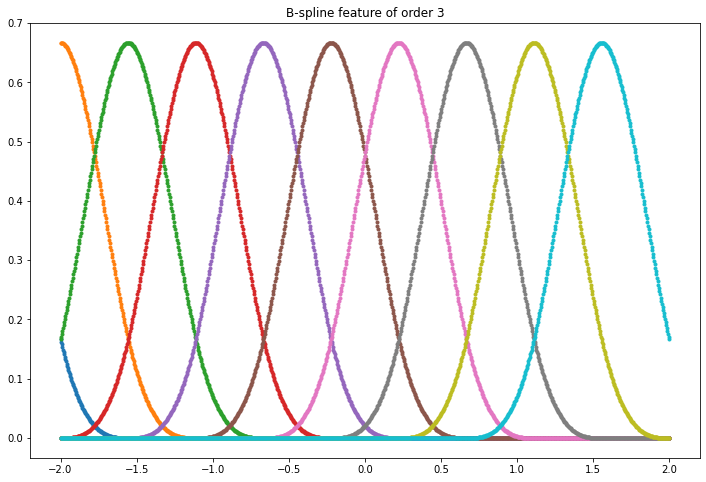

In [27]:
order = 3
knots = np.linspace(-2, 2, 10)
bspf = BSplineFeatures(knots, degree=order, periodic=True)
features = bspf.fit_transform(x_predict[:,None])


plt.figure(figsize=(12,8))
plt.plot(x_predict, features,'.')
plt.title('B-spline feature of order ' + str(order))

In [28]:
features.shape

(1000, 10)

# Compare The Feature-map regressions

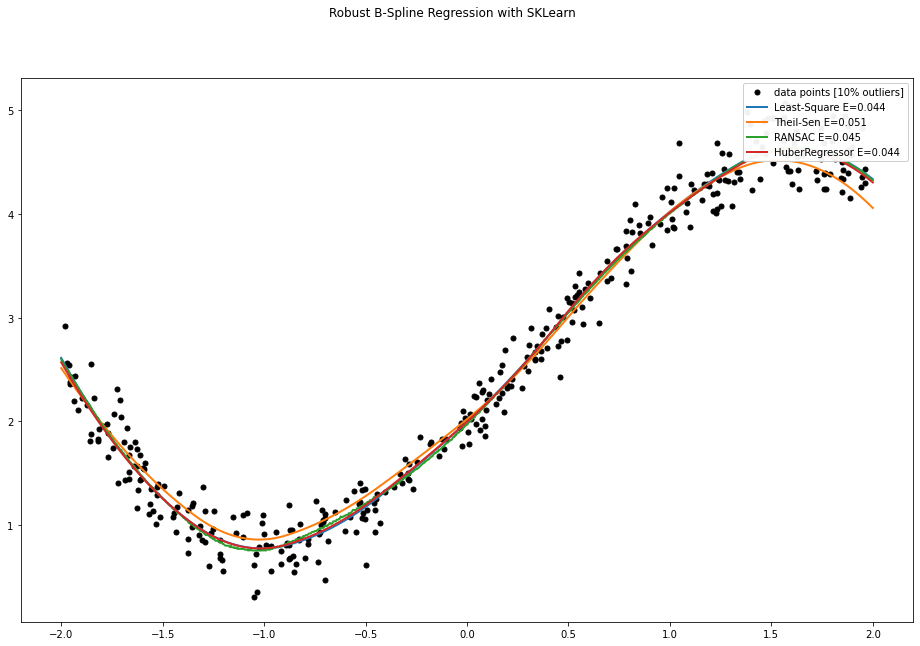

In [29]:
degree = 2
bspline_features = BSplineFeatures(knots, degree=degree, periodic=False)

estimators = [('Least-Square', '-', 'C0', LinearRegression(fit_intercept=False)),
              ('Theil-Sen', '-', 'C1', TheilSenRegressor(random_state=42)),
              ('RANSAC', '-', 'C2', RANSACRegressor(random_state=42)),
              ('HuberRegressor', '-', 'C3', HuberRegressor())]

fig, ax = plt.subplots(1, 1, figsize=(16, 10))
fig.suptitle('Robust B-Spline Regression with SKLearn')
ax.plot(X_train, y_train, 'o', ms=5, c='black',
        label='data points [10% outliers]')

for label, style, color, estimator in estimators:
    model = make_pipeline(bspline_features, estimator)
    model.fit(X_train, y_train)
    mse = mean_squared_error(model.predict(X_test), y_test)
    y_predicted = model.predict(x_predict[:, None])
    ix = np.argsort(x_predict)
    ax.plot(x_predict[ix], y_predicted[ix], style, lw=2,
            color=color, label=label + ' E={:2.2g}'.format(mse))
ax.legend(loc='upper right', framealpha=0.95)
# ax.set(ylim=(-2, 8), xlabel='time [s]', ylabel='amplitude')
plt.show()
